### Data Preparation for Bayesian Filter

install dependencies....

In [1]:
!pip install beautifulsoup4

In [2]:
!pip install wordcloud

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import os
import io
%matplotlib inline

### This function reads the files in the specified path.

In [4]:
def read_files(path):
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root,filename)
            
            inBody = False
            lines = []
            
            f = io.open(path, 'r', encoding = 'latin1')
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            message = '\n'.join(lines)
            yield path, message
                    

### This function is for creating dataframes from the dataset in question... it also classifies the emails into either ham or spam

In [5]:
def dataFrameFromDirectory(path, classification):
    rows = []
    index = []
    for filename, message in read_files(path):
        rows.append({'message': message, 'label': classification})
        index.append(filename)
    return pd.DataFrame(rows, index=index)

aggregate all the emails into a single dataframe. The key is: ham = 0, spam = 1

In [6]:
data = pd.DataFrame({'message':[],'label':[]})
data = data.append(dataFrameFromDirectory("ham-and-spam-dataset/ham",0))
data = data.append(dataFrameFromDirectory("ham-and-spam-dataset/spam",1))
data

,message,label
ham-and-spam-dataset/ham/0582.adc6095d8af63a380672cfd1e881a586,> This is getting better and better. You know ...,0.0
ham-and-spam-dataset/ham/1017.d946df144440633b63b4df3fa3c6082b,"From the local paper this morning.\n\n""Canadi...",0.0
ham-and-spam-dataset/ham/2002.4aee6e78ce794e84f44ccde11f46fd4c,URL: http://boingboing.net/#85485786\n\nDate: ...,0.0
ham-and-spam-dataset/ham/1369.0df084ff7488653baa03642c485c233f,humberto@hpcf.upr.edu wrote:\n\n\n\n>Redhat 8 ...,0.0
ham-and-spam-dataset/ham/0862.91f1d92f60d5789a201c14f2034bbdaa,"On Saturday, September 28, 2002, at 12:54 PM, ...",0.0
...,...,...
ham-and-spam-dataset/spam/0019.939e70d8367f315193e4bc5be80dc262,"DEAR FRIEND,I AM MRS. SESE-SEKO WIDOW OF LATE...",1.0
ham-and-spam-dataset/spam/0299.9d0b292172cb787eb2ed9e8855222edd,Would you like to know what the Powerball Winn...,1.0
ham-and-spam-dataset/spam/0484.cd802b94da9c80db5e4432bb661effd1,"<TABLE id=AutoNumber2 style=""BORDER-COLLAPSE: ...",1.0
ham-and-spam-dataset/spam/0427.8136588f1befaccc01f0405513be6186,\n\n<html>\n\n<head>\n\n\n\n</head>\n\n<body b...,1.0


The below cell shows the number of rows in our dataframe.

In [7]:
total_mails = data['message'].shape[0]
total_mails

3052

The function below extracts all text from html text present in all emails.

In [8]:
from bs4 import BeautifulSoup

def func(df):
    soup = BeautifulSoup(df['message'], "html.parser").find()
    if bool(soup):
        soup = BeautifulSoup(df['message'], "html.parser")
        text = soup.find_all(text=True)
        text = ''.join(word for word in  text)
        df['message'] = text
        
        return text
    else:
        
        return df['message'] 

In [9]:
new_data = data.reset_index()
new_data

,index,message,label
0,ham-and-spam-dataset/ham/0582.adc6095d8af63a38...,> This is getting better and better. You know ...,0.0
1,ham-and-spam-dataset/ham/1017.d946df144440633b...,"From the local paper this morning.\n\n""Canadi...",0.0
2,ham-and-spam-dataset/ham/2002.4aee6e78ce794e84...,URL: http://boingboing.net/#85485786\n\nDate: ...,0.0
3,ham-and-spam-dataset/ham/1369.0df084ff7488653b...,humberto@hpcf.upr.edu wrote:\n\n\n\n>Redhat 8 ...,0.0
4,ham-and-spam-dataset/ham/0862.91f1d92f60d5789a...,"On Saturday, September 28, 2002, at 12:54 PM, ...",0.0
...,...,...,...
3047,ham-and-spam-dataset/spam/0019.939e70d8367f315...,"DEAR FRIEND,I AM MRS. SESE-SEKO WIDOW OF LATE...",1.0
3048,ham-and-spam-dataset/spam/0299.9d0b292172cb787...,Would you like to know what the Powerball Winn...,1.0
3049,ham-and-spam-dataset/spam/0484.cd802b94da9c80d...,"<TABLE id=AutoNumber2 style=""BORDER-COLLAPSE: ...",1.0
3050,ham-and-spam-dataset/spam/0427.8136588f1befacc...,\n\n<html>\n\n<head>\n\n\n\n</head>\n\n<body b...,1.0


split the data into the pareto principle for unbiased model testing.
so 80% will be used for training and 20% for testing.
this will be accomplished by using a random number generator to randomize the order by implementing a uniform distribution randomizer. this removes all chances of having a biased model on account of sequential data.

In [10]:
train_index, test_index = list(), list()
for i in range(data['message'].shape[0]):
    if np.random.uniform(0,1) < 0.80:
        train_index.append(i)
    else:
        test_index.append(i)
        
train_data = new_data.loc[train_index]
test_data = new_data.loc[test_index]

implement the data cleaning of the html based messages
    

In [11]:
train_data['message'] = train_data.apply(func, axis=1)
train_data

/home/ian/snap/jupyter/common/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp






" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


,index,message,label
0,ham-and-spam-dataset/ham/0582.adc6095d8af63a38...,> This is getting better and better. You know ...,0.0
1,ham-and-spam-dataset/ham/1017.d946df144440633b...,"From the local paper this morning.\n\n""Canadi...",0.0
2,ham-and-spam-dataset/ham/2002.4aee6e78ce794e84...,URL: http://boingboing.net/#85485786\n\nDate: ...,0.0
3,ham-and-spam-dataset/ham/1369.0df084ff7488653b...,humberto@hpcf.upr.edu wrote:\n\n\n\n>Redhat 8 ...,0.0
4,ham-and-spam-dataset/ham/0862.91f1d92f60d5789a...,"On Saturday, September 28, 2002, at 12:54 PM, ...",0.0
...,...,...,...
3047,ham-and-spam-dataset/spam/0019.939e70d8367f315...,"DEAR FRIEND,I AM MRS. SESE-SEKO WIDOW OF LATE...",1.0
3048,ham-and-spam-dataset/spam/0299.9d0b292172cb787...,Would you like to know what the Powerball Winn...,1.0
3049,ham-and-spam-dataset/spam/0484.cd802b94da9c80d...,\n\n\n\n\n\nNever Pay Retail!\n\n\n\n\n\n\n\n\...,1.0
3050,ham-and-spam-dataset/spam/0427.8136588f1befacc...,\n\n\n\n\n\n\n\n\n\n\n \n The \n\n ...,1.0


In [12]:
train_data.dtypes

index       object
message     object
label      float64
dtype: object

In [13]:
train_data.size

7281

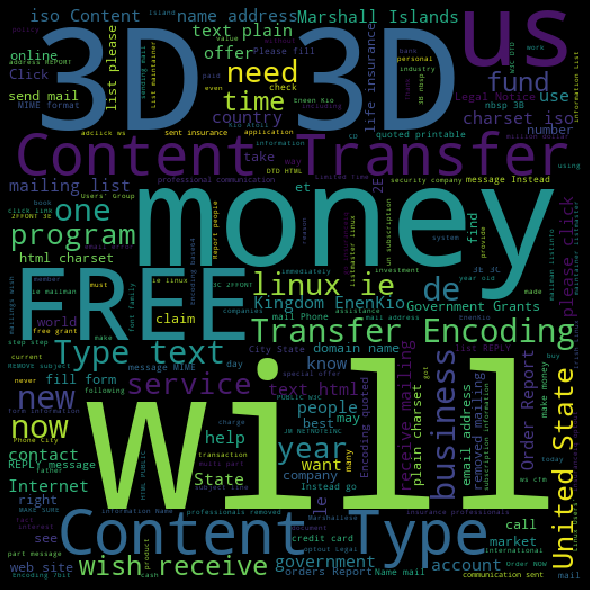

In [14]:
spam_words = ' '.join(str(moja) for moja in list(train_data[train_data['label'] == 1]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

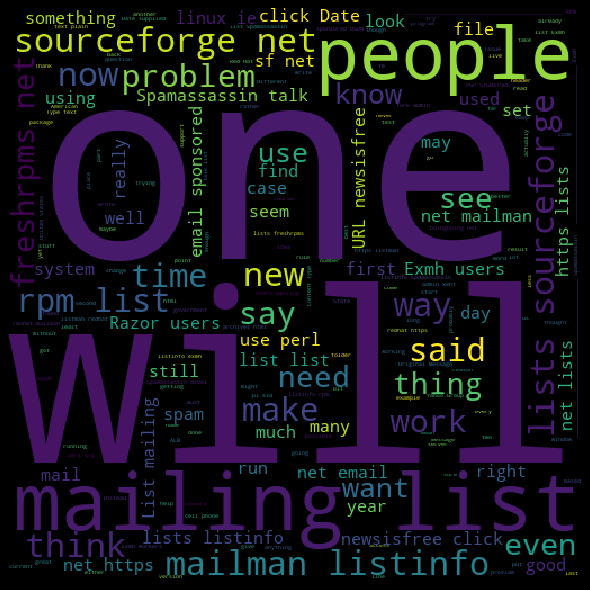

In [15]:
spam_words = ' '.join(str(moja) for moja in list(train_data[train_data['label'] == 0]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

distribution by value

In [16]:
train_data['label'].value_counts()

0.0    2027
1.0     400
Name: label, dtype: int64

in this cell we preprocess the text to be able to be fit into the model.
the first step is to first make all the text lower case for uniformity.
Then we tokenize each message in the dataset.
Tokenization  is the task of splitting up a message into pieces and throwing away the punctuation characters.
The words like ‘go’, ‘goes’, ‘going’ indicate the same activity. We can replace all these words by a single word ‘go’. This is called stemming. We are going to use Porter Stemmer, which is a famous stemming algorithm.

In [17]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    #lower case letters
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [18]:
train_data.columns

Index(['index', 'message', 'label'], dtype='object')

In [19]:
class SpamClassifier(object):
    def __init__(self, train_data, method = 'tf-idf'):
        self.mails, self.labels = train_data['message'], train_data['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        self.missing_index = [number for number in range(0,noOfMessages) if number not in self.mails.index ]
        for i in range(noOfMessages):
            if i not in self.missing_index:
                message_processed = process_message(self.mails[i])
                count = list() #To keep track of whether the word has ocured in the message or not.
                               #For IDF
                for word in message_processed:
                    if self.labels[i]:
                        self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                        self.spam_words += 1
                    else:
                        self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                        self.ham_words += 1
                    if word not in count:
                        count += [word]
                for word in count:
                    if self.labels[i]:
                        self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                    else:
                        self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [20]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [21]:
sc_bow = SpamClassifier(train_data, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(test_data['message'])
metrics(test_data['label'], preds_bow)

ValueError: math domain error

In [ ]:
sc_tf_idf = SpamClassifier(train_data, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(test_data['message'])
metrics(testData['label'], preds_tf_idf)


In [ ]:
pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

In [ ]:
pm = process_message('Congratulations ur awarded $500 ')
sc_tf_idf.classify(pm)

In [ ]:
train_data.reset_index(drop=True)

In [ ]:
-